In [1]:
# SET UP (it will take a long time to run)
using Pkg; Pkg.activate("C:/Users/nicot/GitHub/Tutorial_DynMacro")
using Plots; using Optim; using Interpolations; using LinearAlgebra; using Distributions
Pkg.status()

  Activating environment at `C:\Users\nicot\GitHub\Tutorial_DynMacro\Project.toml`

      Status `D:\GitHub\Tutorial_DynMacro\Project.toml`


  [31c24e10] Distributions v0.23.11
  [2774e3e8] NLsolve v4.5.1
  [429524aa] Optim v1.4.1
  [fcd29c91] QuantEcon v0.16.2


# Bipolar cake eater
**Taste shocks**

Let's reframe the previous problem whith taste shocks. When it rains I really like to eat cake, when it's sunny not so much. This shocks are represented by $\epsilon_t$ that are a markov chain with transition matrix $\Pi$.

Bellman's equation is:
$$
V(K,\epsilon)=max_{K'} \big\{ \epsilon \; u(K-K') + \beta E_\epsilon \big[V(K',\epsilon')\big] \big\}
$$

Expanding the expectation we have
$$
V(K,\epsilon) = max_{K'} \big\{ \epsilon \; u(K-K') + \beta \big[ \pi(\epsilon|\epsilon) V(K',\epsilon) + \pi(\epsilon'|\epsilon) V(K',\epsilon') \big] \big\}
$$


In [137]:
γ = 0.5    # En este problema vamos a querer que u este acotada por abajo para garantizar Blackwell, entonces γ<1
β= 0.96
u(c) = γ==1.0 ?  log(c)  :  c^(1-γ)/(1-γ)   # CRRA

# Proceso estocástico
Z_grid=[1.2 0.8]
#Operador esperanza incluir con la matriz de transición PIMAYUSCULA:
Π=[0.9 0.1 ; 
   0.5 0.5]
#tienen que sumar las filas a un valor de 1
#filas estado inicial
#columnas: estado final

#definir una grilla para el capital. max valor: 1000 (k_max)
k_min=1e-10
k_max=1000
n=500 # grid points
K_grid = range(k_min, k_max, length=n)



1.0e-10:2.0040080160318636:1000.0

In [138]:
# First guess. Puede ser cualquier cosa.
V_0(k, z)=u(k)*Z_grid[z] # Forma funcional de la first guess
V_0_mat = zeros(length(Z_grid),length(K_grid)) # Inicializo una matirz (primero llena de 0s, luego la completo)
V_0_mat[1,:] = V_0.(K_grid,1)
V_0_mat[2,:] = V_0.(K_grid,2)
V_0_mat

2×500 Matrix{Float64}:
 2.4e-5  3.39751  4.80481  5.88466  …  75.6662  75.7424  75.8186  75.8947
 1.6e-5  2.26501  3.2032   3.92311     50.4441  50.4949  50.5457  50.5964

In [139]:
#PRIMERA ITERACION

V_lin(z) = LinearInterpolation(K_grid, V_0_mat[z,:], extrapolation_bc = Line())
#nos dice anada a la fila z y hace una interpolación para obtener el valor V en cualquier k

# Ejemplo:
V_lin(1)(25.2)

#función objetivo:
fobjetivo(z, k, k_new)=Z_grid[z]*u(k-k_new)+β * Π[z,:]' * [V_lin(z_new)(k_new) for z_new in 1:2]

# Ejemplo quiero encontrar el k_new que maximiza si z=1 y k=500
fobjetivo_ej(k_new) = fobjetivo(1,500,k_new) 
maximize(fobjetivo_ej, k_min, 500) # las cotas de k_new son k_min y 500


Results of Maximization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 500.000000]
 * Maximizer: 2.312284e+02
 * Maximum: 7.321338e+01
 * Iterations: 12
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 13

In [140]:
#ZOOM en la parte de la esperanza

#Ejemplo si k_new=50
@show V_lin(1)(50) #z_new = 1.05
@show V_lin(2)(50) ##z_new = 0.95
@show [V(z_new)(50) for z_new in 1:2]

# Si hoy z=1.05 entonces las probabilidades del nuevo estado son:
Π[1,:]'

# El valor esperado condicional a que hoy z=1.05 es
@show Π[1,1]*V_lin(1)(50)+Π[1,2]*V_lin(2)(50)

# De manera idéntica:
@show Π[1,:]'*[V(z_new)(50) for z_new in 1:2]

;

(V_lin(1))(50) = 16.970397890271233
(V_lin(2))(50) = 11.313598593514158
[(V(z_new))(50) for z_new = 1:2] = [16.970397890271233, 11.313598593514158]
Π[1, 1] * (V_lin(1))(50) + Π[1, 2] * (V_lin(2))(50) = 16.404717960595526
(Π[1, :])' * [(V(z_new))(50) for z_new = 1:2] = 16.404717960595526


In [141]:
# AHORA QUIERO HACER LO MISMO PERO PARA MUCHOS VALORES DE K (no solo k=500)

# k_new es la variable que quiero elegir, además quiero iterar en cada punto de k
fobjetivo_vec_ej = (k_new -> fobjetivo(1,k,k_new) for k in K_grid) #un vector que dependen de k_new obtengo

results = maximize.(fobjetivo_vec_ej, 1e-10, K_grid) #maximizo cada función del vector de funcions
# la cota inferior es siempre k_min, pero la cota superior cambia (por ej., si la torata es de tamaño 200, entonces es 200)

maximos_ej = Optim.maximum.(results)    
maximizadores_ej = Optim.maximizer.(results)

500-element Vector{Float64}:
   1.0e-10
   1.4222402626733224
   2.004008025643627
   2.6212809509593926
   4.0080160428677996
   4.261214362580462
   6.012024037996608
   6.0120241445984215
   7.929199088493811
   8.016032108007852
   9.600828887128534
  10.020040078282761
  11.275884709563407
   ⋮
 452.90580712458666
 452.90581809676286
 454.8904317077062
 454.90982222298845
 456.57141785445117
 456.9138311425401
 458.2523691036417
 458.91783157085814
 459.9333650571591
 460.9218436006912
 461.6143536413416
 462.92585241534783

In [142]:
# JUNTO TODO ESTE PROCEDIMIENTO EN UNA FUNCIÓN
function T(V_mat)
    # Come una matriz que representa la función V que uso como input
    # Para poder obtener la imagen de la función V para valores de K fuera de la grilla debo interpolar
    V(z) = LinearInterpolation(K_grid, V_mat[z,:], extrapolation_bc = Line())
    
    #Inicializo una matriz vacía para la proxima V y la función de política g
    V_new=zeros(length(Z_grid),length(K_grid))
    g_new=zeros(length(Z_grid),length(K_grid))
    
    # Defino la función objetivo
    fobjetivo(z, k, k_new) = Z_grid[z]*u(k-k_new) + β * Π[z,:]' * [V(z_new)(k_new) for z_new in 1:2]

    
    # Para cada z
    for zz in 1:2
        # construyo un vector de funciones objetivos, que dependen solo de k_new
        fobjetivo_vec = (k_new -> fobjetivo(zz,kk,k_new) for kk in K_grid) # para z=zz y para k=kk
        results = maximize.(fobjetivo_vec, k_min,K_grid) 
        V_new[zz,:] = Optim.maximum.(results)
        g_new[zz,:] = Optim.maximizer.(results)
    end
    
    return [V_new, g_new]
end

T (generic function with 1 method)

In [143]:
V_old=V_0_mat

2×500 Matrix{Float64}:
 2.4e-5  3.39751  4.80481  5.88466  …  75.6662  75.7424  75.8186  75.8947
 1.6e-5  2.26501  3.2032   3.92311     50.4441  50.4949  50.5457  50.5964

In [151]:
V_new=T(V_old)[1]
@show norm(V_new-V_old) #diferencia
V_old=V_new


norm(V_new - V_old) = 172.08991778247284


2×500 Matrix{Float64}:
 1.63521e-5  6.33796  10.2515   …  187.326  187.514  187.703  187.891
 1.63483e-5  5.89183   9.52856     173.201  173.375  173.55   173.724

Number of iterations: 177
Distance between last two value functions: 9.631765124611279e-5


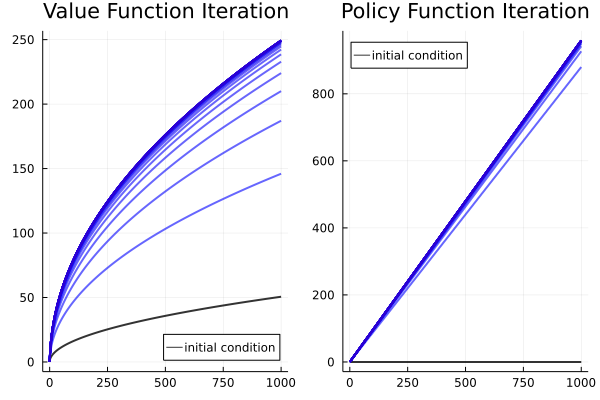

In [152]:
V_mat = V_0_mat
g_mat = zeros(length(Z_grid),length(K_grid)) # matrix

pltV=plot(K_grid, V_mat[2,:], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")
pltg=plot(K_grid, g_mat[2,:], color = :black, linewidth = 2, alpha = 0.8, label = "initial condition")

max_iter = 1000   
tol = 0.0001 # tolerance, if distance is below that I'm fine
distance=tol+1 # some initial condition for distance

i=1
while i < max_iter && distance > tol
    global V_new, g_new = T(V_mat)
    if mod(i,5)==0
        plot!(pltV,K_grid, V_new[2,:], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
        plot!(pltg,K_grid, g_new[2,:], color = RGBA(i/max_iter, 0, 1 - i/max_iter, 0.8), linewidth = 2, alpha = 0.6, label = "")
    end
    distance = norm(V_new - V_mat)
    i += 1
    V_mat = V_new  # copy contents into v.  Also could have used v[:] = v_next
end
g_fun(z)=LinearInterpolation(K_grid, g_new[z,:], extrapolation_bc = Line()) # policy function K_t => K_t+1

println("Number of iterations: ",i,"\nDistance between last two value functions: ",distance)

plot!(pltV, legend = :bottomright, title="Value Function Iteration")
plot!(pltg, legend = :topleft, title="Policy Function Iteration")
plot(pltV, pltg)

In [153]:
function cadena_simu(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # es una matriz cuadrada?
    N = size(P)[1]

    dists = [Categorical(P[i, :]) for i in 1:N]  # crea N distribuciones

    X = fill(0, sample_size) # crea un vector
    X[1] = init # primer estado

    for t in 2:sample_size
        dist = dists[X[t-1]] # selecciona la distribucion correspondiente
        X[t] = rand(dist) # saca un valor aleatorio segun la distribución
    end
    return X
end

cadena_simu (generic function with 1 method)

In [154]:
Time=100
Z_simu = cadena_simu(Π, init = 1, sample_size = Time)

100-element Vector{Int64}:
 1
 1
 1
 2
 2
 1
 1
 2
 2
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [155]:
c_path = fill(0.0, Time)
K_path = fill(0.0, Time)
K_path[1] = 1000.0 


1000.0

In [156]:
for t in 2:(Time)  
    K_path[t] = g_fun(Z_simu[t-1])(K_path[t-1])
    c_path[t-1] = K_path[t-1] - K_path[t]
end
c_path[Time] = g_fun(Z_simu[Time])(K_path[Time]) - K_path[Time]

-0.04939720836001649

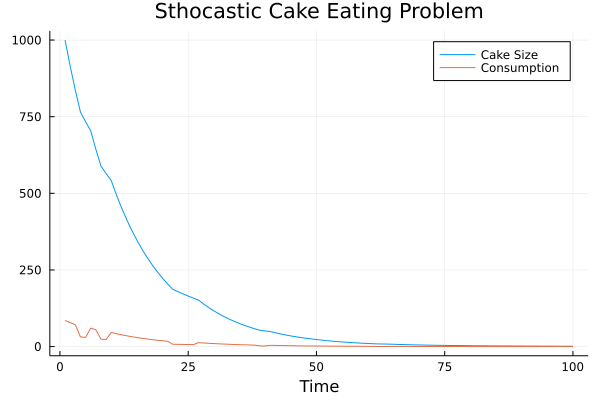

In [157]:
plot(1:Time,K_path,label="Cake Size",title="Sthocastic Cake Eating Problem",xlabel="Time")
#plot!(1:Time,c_path,label="Consumption")
plot!(1:Time,c_path,label="Consumption")